# Extract data from Metabolic Atlas via Human-GEM

Purpose of this notebook is to extract and format Human-GEM data for subsequent model annotation

## Notebook Requirements:
*  Note: Requires internet connection to retrieve latest files from the [MetabolicAtlas Human-GEM repository](https://github.com/SysBioChalmers/Human-GEM).

### Citations

Robinson JL, Kocabaş P, Wang H, Cholley PE, Cook D, Nilsson A, Anton M, Ferreira R, Domenzain I, Billa V, Limeta A, Hedin A, Gustafsson J, Kerkhoven EJ, Svensson LT, Palsson BO, Mardinoglu A, Hansson L, Uhlén M, Nielsen J. An atlas of human metabolism. Sci Signal. 2020 Mar 24;13(624):eaaz1482. doi: 10.1126/scisignal.aaz1482. PMID: 32209698; PMCID: PMC7331181.

## Setup
### Import packages

In [1]:
from warnings import warn

import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    ANNOTATION_PATH,
    DATABASE_PATH,
    INTERIM_PATH,
    ROOT_PATH,
    build_string,
    check_version,
    compare_tables,
    explode_column,
    get_annotation_df,
    read_cobra_model,
    read_rbc_model,
    show_versions,
    visualize_comparison,
)
from rbc_gem_utils.database.metatlas import (
    HUMANGEM_DB_TAG,
    HUMANGEM_MIRIAM,
    HUMANGEM_PATH,
    HUMANGEM_VERSION_EXPECTED,
    download_database_HumanGEM,
    get_annotations_HumanGEM,
    get_version_HumanGEM,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check Human-GEM version
If the Human-GEM version does not match the expected version, it is because Human-GEM has been updated since the last time this code was utilized. 
### Expected HumanGEM version: 1.19.0

In [2]:
version = get_version_HumanGEM()
if check_version(version, HUMANGEM_VERSION_EXPECTED, verbose=True):
    database_dirpath = ROOT_PATH / DATABASE_PATH / HUMANGEM_PATH
    annotation_dirpath = ROOT_PATH / ANNOTATION_PATH
else:
    database_dirpath = ROOT_PATH / INTERIM_PATH / HUMANGEM_PATH
    annotation_dirpath = ROOT_PATH / INTERIM_PATH
    version = HUMANGEM_VERSION_EXPECTED

Current and expected versions match.


#### Download new files and update database
If an argument is not provided (`arg=None`), its default value for the repository used. 

In [3]:
# Download data into interim directory
download = True
if download:
    download_database_HumanGEM(
        annotation_type={"metabolites", "reactions", "genes"},
        database_dirpath=database_dirpath,
        model_filetype={"xml", "yml"},
        model_version=version,
    )

## Load RBC-GEM model

In [4]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,145c0d410
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Set notebook options

In [5]:
compare = True
display_nunique = True
overwrite = True
compare_figsize = (5, 5)
db_tag = HUMANGEM_DB_TAG

## Reactions

* `reactions.tsv` content:

|# |fieldname      |annotation               |Prefixes (https://identifiers.org/)|
|--|---------------|-------------------------|-----------------------------------|
|1 |rxns           |identical to `model.rxns`|metatlas                           |
|2 |rxnKEGGID      |KEGG reaction ID         |kegg.reaction                      |
|3 |rxnBiGGID      |BiGG reaction ID         |bigg.reaction                      |
|4 |rxnEHMNID      |EHMN reaction ID         |                                   |
|5 |rxnHepatoNET1ID|HepatoNET1 reaction ID   |                                   |
|6 |rxnREACTOMEID  |REACTOME ID              |reactome                           |
|7 |rxnRecon3DID   |Recon3D reaction ID      |vmhreaction                        |
|8 |rxnMetaNetXID  |MetaNetX reaction ID     |metanetx.reaction                  |
|9 |rxnHMR2ID      |HMR2 reaction ID         |                                   |
|10|rxnRatconID    |Ratcon reaction ID       |                                   |
|11|rxnTCDBID      |TCDB ID                  |tcdb                               |
|12|spontaneous    |Spontaneous status       |                                   |
|13|rxnRheaID      |Rhea ID                  |rhea                               |
|14|rxnRheaMasterID|Master Rhea ID           |rhea                               |
|15|rxnRetired     |Retired reaction IDs     |                                   |

##### Notes

* `spontaneous` status column is included.
* Otherwise, include columns that link to https://identifiers.org/.
* For `rhea`:
    * The master Rhea ID is utilized for the annotation.
    * The "RHEA:" prefix from Rhea IDs needs to be stripped.
* `ec-code` annotations are currently stored in the model file.

In [6]:
HumanGEM = read_cobra_model(database_dirpath / "Human-GEM.xml")
HumanGEM

Name,HumanGEM
Memory address,147472450
Number of metabolites,8455
Number of reactions,12971
Number of genes,2887
Number of groups,148
Objective expression,1.0*MAR13082 - 1.0*MAR13082_reverse_11d67
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [7]:
annotation_type = "reactions"
mapping_key = "metatlas"
merge_key = "rxnMetAtlas"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()

del annotation_columns["rxnRheaID"]
annotation_columns = list(annotation_columns) + ["spontaneous", "ec-code"]
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)
df_model

,reactions,metatlas
0,UNK3,MAR05391
1,4PYRDXABCte,MAR08103
2,5AOPt2,MAR11307
3,EX_ade_e,MAR09250
4,EX_adn_e,MAR09251
...,...,...
3270,SK_avite1qn_c,<NA>
3271,SK_prdx2crd_c,<NA>
3272,SK_prdx2cso3_c,<NA>
3273,SK_grdx2crd_c,<NA>


reactions: 3275
metatlas: 1596
kegg.reaction: 525
bigg.reaction: 850
reactome: 14
vmhreaction: 1626
metanetx.reaction: 1153
tcdb: 31
rhea: 442
spontaneous: 2
ec-code: 385


,reactions,metatlas,kegg.reaction,bigg.reaction,reactome,vmhreaction,metanetx.reaction,tcdb,rhea,spontaneous,ec-code
0,UNK3,MAR05391,R07396,<NA>,<NA>,UNK3r,MNXR95923,<NA>,25796,0,2.6.1.5
1,4PYRDXABCte,MAR08103,<NA>,4PYRDX,<NA>,4PYRDX,MNXR95053,<NA>,<NA>,0,<NA>
2,5AOPt2,MAR11307,<NA>,5AOPt2,<NA>,5AOPt2,MNXR95061,<NA>,<NA>,0,<NA>
3,EX_ade_e,MAR09250,<NA>,EX_ade_e,<NA>,EX_acnacngal14acglcgalgluside_hs[e],<NA>,<NA>,<NA>,0,<NA>
4,EX_adn_e,MAR09251,<NA>,EX_adn_e,<NA>,EX_acnacngalgbside_hs[e],<NA>,<NA>,<NA>,0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
3270,SK_avite1qn_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3271,SK_prdx2crd_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3272,SK_prdx2cso3_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3273,SK_grdx2crd_c,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


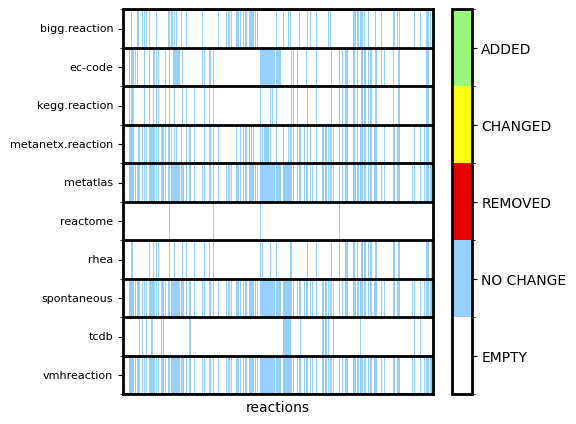

In [8]:
df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"rxns": merge_key}, axis=1)
df_annotations = df_annotations.merge(
    pd.DataFrame.from_dict(
        {
            rxn.id: build_string(rxn.annotation.get("ec-code", []))
            for rxn in HumanGEM.reactions
            if rxn.annotation.get("ec-code", [])
        },
        orient="index",
        columns=["ec-code"],
    ),
    left_on=merge_key,
    right_index=True,
    how="left",
)

df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)

if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)
    # Clean up Rhea if MIRIAM formats are being applied
    if "rhea" in df_annotations.columns:
        df_annotations["rhea"] = df_annotations["rhea"].str.lstrip("RHEA:")

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations

## Metabolites

* `metabolites_Human-GEM.tsv` content:

|# |fieldname      |annotation                             |Prefixes (https://identifiers.org/)|
|--|---------------|---------------------------------------|-----------------------------------|
|1 |mets           |identical to `model.mets`              |metatlas                           |
|2 |metsNoComp     |`model.mets` without compartment suffix|                                   |
|3 |metBiGGID      |BiGG metabolite ID                     |bigg.metabolite                    |
|4 |metKEGGID      |KEGG metabolite ID                     |kegg.compound                      |
|5 |metHMDBID      |HMDB ID                                |hmdb                               |
|6 |metChEBIID     |ChEBI ID                               |chebi                              |
|7 |metPubChemID   |PubChem ID                             |pubchem.compound                   |
|8 |metLipidMapsID |LipidMaps ID                           |lipidmaps                          |
|9 |metEHMNID      |EHMN metabolite ID                     |                                   |
|10|metHepatoNET1ID|HepatoNET1 metabolite ID               |                                   |
|11|metRecon3DID   |Recon3D metabolite ID                  |vmhmetabolite                      |
|12|metMetaNetXID  |MetaNetX metabolite ID                 |metanetx.chemical                  |
|13|metHMR2ID      |HMR2 metabolite ID                     |                                   |
|14|metRetired     |Retired metabolite IDs                 |                                   |

##### Notes

* Include columns that link to https://identifiers.org/.
* `inchi` annotations are currently stored in the model file.

In [9]:
annotation_type = "metabolites"
mapping_key = "metatlas"
merge_key = "metMetAtlas"
rename_miriam = True

annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
annotation_columns = list(annotation_columns) + ["inchi"]
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)
df_model

,metabolites,metatlas
0,13dpg_c,MAM00247c
1,23dpg_c,MAM00569c
2,2kmb_c,MAM01016c
3,2pg_c,MAM00674c
4,35cgmp_c,MAM01433c
...,...,...
2152,3mob_e,<NA>
2153,crm_hs_e,<NA>
2154,alltn_e,<NA>
2155,3dfru_e,<NA>


metabolites: 2157
metatlas: 1410
bigg.metabolite: 728
kegg.compound: 767
hmdb: 418
chebi: 694
pubchem.compound: 676
lipidmaps: 224
vmhmetabolite: 1141
metanetx.chemical: 1173
inchi: 129


,metabolites,metatlas,bigg.metabolite,kegg.compound,hmdb,chebi,pubchem.compound,lipidmaps,vmhmetabolite,metanetx.chemical,inchi
0,13dpg_c,MAM00247c,13dpg,C00236,<NA>,CHEBI:16001,439191,<NA>,13dpg,MNXM261,<NA>
1,23dpg_c,MAM00569c,23dpg,C01159,<NA>,CHEBI:17720,<NA>,<NA>,23dpg,MNXM146487;MNXM892,<NA>
2,2kmb_c,MAM01016c,2kmb,C01180,<NA>,CHEBI:33574,<NA>,LMFA01060170,2kmb,MNXM276,<NA>
3,2pg_c,MAM00674c,2pg,C00631,<NA>,CHEBI:17835,439278,<NA>,2pg,MNXM275,<NA>
4,35cgmp_c,MAM01433c,35cgmp,C00942,HMDB0001314,CHEBI:16356,24316,<NA>,35cgmp,MNXM665,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2152,3mob_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2153,crm_hs_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2154,alltn_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2155,3dfru_e,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


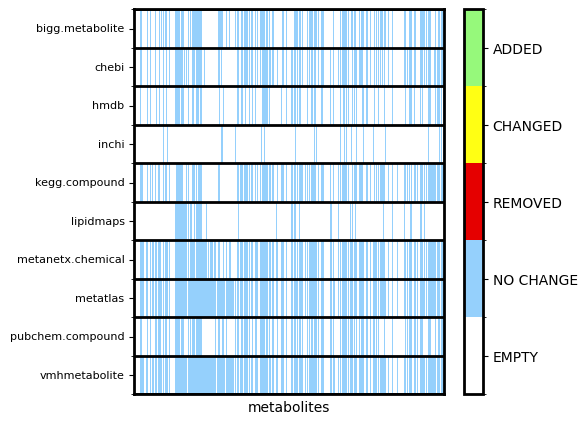

In [10]:
df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"mets": merge_key}, axis=1)
df_annotations = df_annotations.merge(
    pd.DataFrame.from_dict(
        {
            met.id: build_string(met.annotation.get("inchi", []))
            for met in HumanGEM.metabolites
            if met.annotation.get("inchi", [])
        },
        orient="index",
        columns=["inchi"],
    ),
    left_on=merge_key,
    right_index=True,
    how="left",
)
df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)
if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]
if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)

df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations

## Genes

* `genes_Human-GEM.tsv` content:

|# |fieldname     |  annotation          |Prefixes (https://identifiers.org/)|
|--|--------------|----------------------|-----------------------------------|
|1 |genes         |Ensembl gene ID       |ensembl                            |
|2 |geneENSTID    |Ensembl transcript ID |ensembl                            |
|3 |geneENSPID    |Ensembl protein ID    |ensembl                            |
|4 |geneUniProtID |UniProt ID            |uniprot                            |
|5 |geneSymbols   |Gene Symbol           |hgnc.symbol                        |
|6 |geneEntrezID  |NCBI Entrez ID        |ncbigene                           |
|7 |geneNames     |Gene Name             |                                   |
|8 |geneAliases   |Alias Names           |                                   |
|9 |compartments  |Subcellular location  |                                   |
|10|compDataSource|Source for compartment|                                   |


##### Notes
* Unlike `reactions` and `metabolites`, the Human-GEM reconstruction does not have its own unique identifiers for genes but instead uses the 'Ensembl gene ID'. Therefore, slight alterations to the code are made to account for differences. 
* It is recommended to unify model with annotations using the NCBI Entrez ID or the UniProt ID.
* Include columns that link to https://identifiers.org/.
* For `ensembl`, the Ensembl gene ID is utilized for the annotation.

In [11]:
annotation_type = "genes"
mapping_key = "uniprot"
merge_key = "geneUniProtID"
rename_miriam = True
annotation_columns = HUMANGEM_MIRIAM[annotation_type].copy()
# Two mappings, only keep ensemble genes
del annotation_columns["geneENSTID"]
del annotation_columns["geneENSPID"]
annotation_columns = list(annotation_columns)
df_model = get_annotation_df(getattr(model, annotation_type), [mapping_key]).rename(
    {"id": annotation_type}, axis=1
)

genes: 820
ensembl: 557
uniprot: 557
hgnc.symbol: 557
ncbigene: 558


,genes,ensembl,uniprot,hgnc.symbol,ncbigene
0,RPE,ENSG00000197713,Q96AT9,RPE,6120
1,RPIA,ENSG00000153574,P49247,RPIA,22934
2,SORD,ENSG00000140263,Q00796,SORD,6652
3,AKR7A2,ENSG00000053371,O43488,AKR7A2,8574
4,SRM,ENSG00000116649,P19623,SRM,6723
...,...,...,...,...,...
815,USP5,ENSG00000111667,P45974,USP5,8078
816,VCPIP1,<NA>,<NA>,<NA>,<NA>
817,VPS4B,<NA>,<NA>,<NA>,<NA>
818,WDR77,<NA>,<NA>,<NA>,<NA>


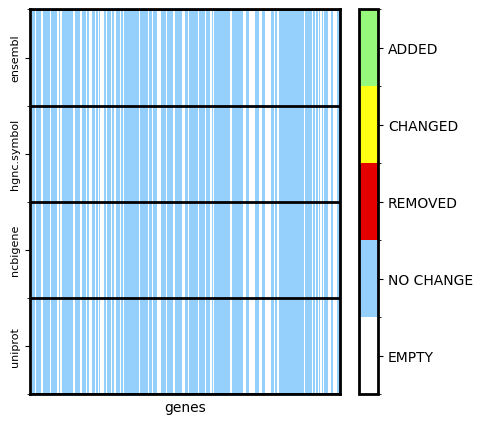

In [12]:
df_annotations = get_annotations_HumanGEM(annotation_type, database_dirpath)
df_annotations = df_annotations.rename({"genes": "geneEnsemblID"}, axis=1)
df_annotations = df_model.merge(
    df_annotations,
    left_on=mapping_key,
    right_on=merge_key if merge_key is not None else mapping_key,
    how="left",
)
if merge_key is not None and merge_key != mapping_key:
    df_annotations = df_annotations.drop(mapping_key, axis=1)

df_annotations = df_annotations.loc[:, [annotation_type] + annotation_columns]

if rename_miriam:
    df_annotations = df_annotations.rename(HUMANGEM_MIRIAM[annotation_type], axis=1)


df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = explode_column(df_annotations, name=col, sep=";")
        df = df[col].drop_duplicates()
        print(f"{df.name}: {df.nunique()}")

if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )
else:
    df_annotations.to_csv(
        ROOT_PATH / INTERIM_PATH / f"{annotation_type}_{db_tag}.tsv",
        sep="\t",
        index=False,
    )
df_annotations